In [1]:
%%sh

pip install --upgrade --no-deps --force-reinstall git+https://github.com/maxim-borisyak/viola-jones.git@master

  Cloning https://github.com/maxim-borisyak/viola-jones.git (to master) to /tmp/pip-G4IPDw-build
  Found existing installation: vjcascades 1.0.0
    Uninstalling vjcascades-1.0.0:
      Successfully uninstalled vjcascades-1.0.0
  Running setup.py install for vjcascades: started
    Running setup.py install for vjcascades: finished with status 'done'


In [2]:
%env THEANO_FLAGS='device=cpu', 'floatX=float32'

env: THEANO_FLAGS='device=cpu', 'floatX=float32'


In [3]:
import numpy as np

import theano
import theano.tensor as T

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from lasagne import updates

from collections import OrderedDict

In [4]:
### http://g.sweyla.com/blog/2012/mnist-numpy/
import mnist

In [5]:
%%sh

mkdir -p mnist && {
    cd mnist;
    wget -q -nc http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz &&
    wget -q -nc http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz &&
    wget -q -nc http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz &&
    wget -q -nc http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz &&
    gunzip *.gz
}

gzip: t10k-images-idx3-ubyte already exists;	not overwritten
gzip: t10k-labels-idx1-ubyte already exists;	not overwritten
gzip: train-images-idx3-ubyte already exists;	not overwritten
gzip: train-labels-idx1-ubyte already exists;	not overwritten


In [6]:
X, y = mnist.load_mnist(dataset='training', path='mnist/')
X = X.reshape(-1, 28, 28).astype('float32')

X_test, y_test = mnist.load_mnist(dataset='testing', path='mnist/')
X_test = X_test.reshape(-1, 28, 28).astype('float32')

In [7]:
for i in range(y.shape[0]):
    y[i] = -1 if y[i] % 2 == 0 else 1

for i in range(y_test.shape[0]):
    y_test[i] = -1 if y_test[i] % 2 == 0 else 1

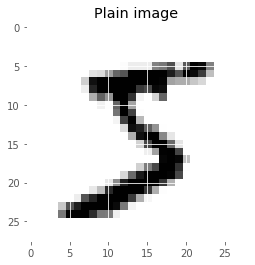

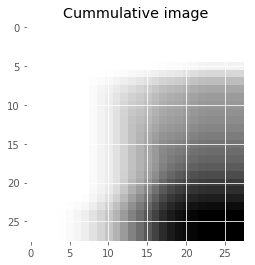

In [8]:
plt.figure()
plt.title('Plain image')
plt.imshow(X[0], cmap=plt.cm.gray_r)

plt.figure()
plt.title('Cummulative image')
x_acc = np.cumsum(np.cumsum(X[0], axis=1), axis=0)
plt.imshow(x_acc, cmap=plt.cm.gray_r)

In [9]:
from vjcascades import ViolaJonesBoost

In [10]:
boost = ViolaJonesBoost(
    n_filters=128,
    batch_size=8,
    subsampling=0.05,
    annealing_rounds=8
)

In [11]:
losses = np.zeros(boost.filters.shape[0])
try:
    from tqdm import tqdm_notebook
    for i, ls in enumerate(tqdm_notebook(boost.train(X, y), total=boost.filters.shape[0])):
        losses[i] = np.mean(ls)
except ImportError:
    for i, ls in enumerate(boost.train(X, y)):
        losses[i] = np.mean(ls)

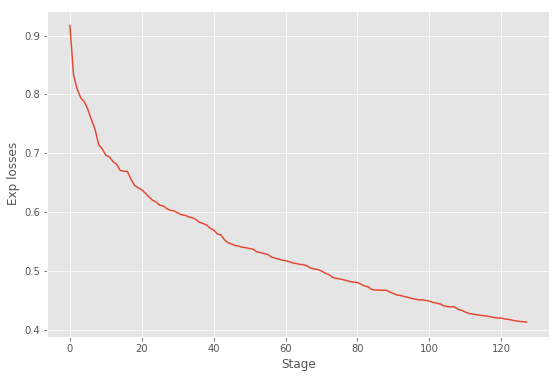

In [12]:
plt.figure(figsize=(9, 6))
plt.plot(losses)
plt.xlabel('Stage')
plt.ylabel('Exp losses')
plt.show()

In [13]:
boost.save('VJBoost.npz')

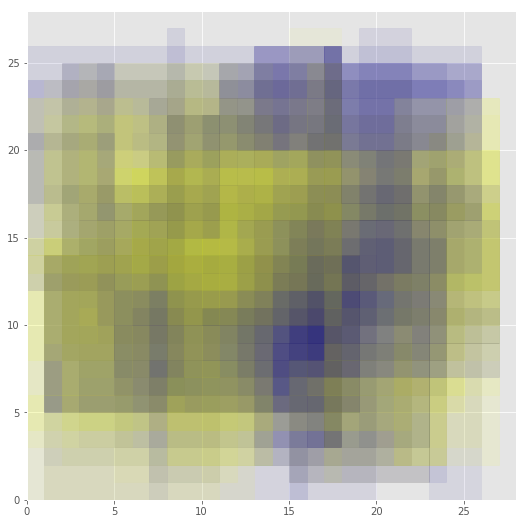

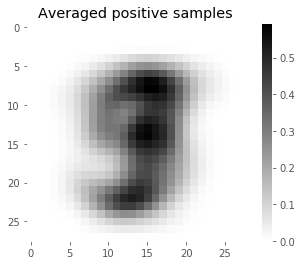

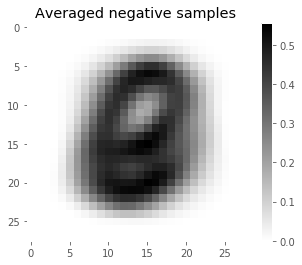

In [21]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors
import matplotlib.cm as cm

filters = boost.filters
alphas = boost.alphas

fig1 = plt.figure(figsize=(9, 9))
ax1 = fig1.add_subplot(111, aspect='equal')

ax1.set_xlim([0, 28])
ax1.set_ylim([0, 28])

cmap = cm.ScalarMappable(norm=colors.Normalize(0.0, 1.0), cmap=plt.cm.plasma)

for f, a in zip(filters, alphas):
    x_ = np.min([f[:, 0]])
    y_ = np.min([f[:, 1]])
    orientation = 1 if (f[0, 0] - f[1, 0]) * (f[0, 1] - f[1, 1]) > 0 else 0
    w = abs(f[0, 0] - f[1, 0])
    h = abs(f[0, 1] - f[1, 1])
    
    ax1.add_patch(
        patches.Rectangle(
            (x_, y_), w, h, alpha=a, color=cmap.to_rgba(orientation)
        )
    )

plt.show()


X_positive = np.mean(X[y == 1], axis=0)
X_negative = np.mean(X[y == -1], axis=0)

plt.figure()
plt.title('Averaged positive samples')
plt.imshow(X_positive, interpolation='None', cmap=plt.cm.gray_r)
plt.colorbar()
plt.grid('off')
plt.show()

plt.figure()
plt.title('Averaged negative samples')
plt.imshow(X_negative,  interpolation='None', cmap=plt.cm.gray_r)
plt.colorbar()
plt.grid('off')
plt.show()

In [22]:
proba = boost.predict(X_test)

In [23]:
from sklearn.metrics import roc_auc_score, roc_curve

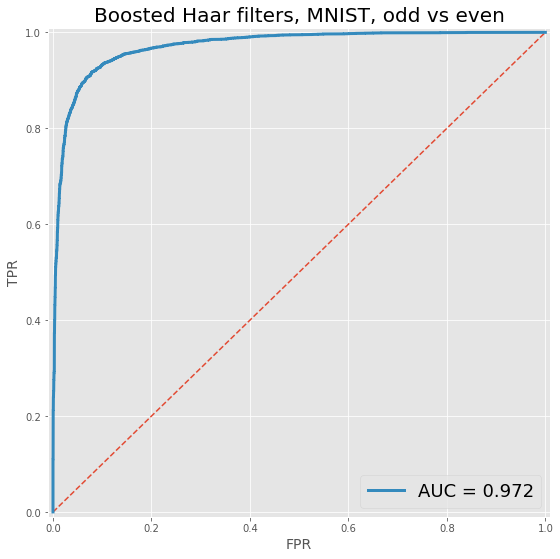

In [24]:
score = roc_auc_score(y_test, proba)
fpr, tpr, _ = roc_curve(y_test, proba)

plt.figure(figsize=(9, 9))
plt.title('Boosted Haar filters, MNIST, odd vs even', fontsize=20)
plt.plot([0, 1], [0, 1], '--')
plt.plot(fpr, tpr, lw=3, label='AUC = %.3lf' % score)
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.legend(loc='lower right', fontsize=18)
plt.xlabel('FPR', fontsize=14)
plt.ylabel('TPR', fontsize=14)
plt.show()

In [25]:
staged_proba = boost.stage_predict(X_test)

In [26]:
aucs = np.zeros(shape=staged_proba.shape[1])

for i in range(staged_proba.shape[1]):
    aucs[i] = roc_auc_score(y_test, staged_proba[:, i])

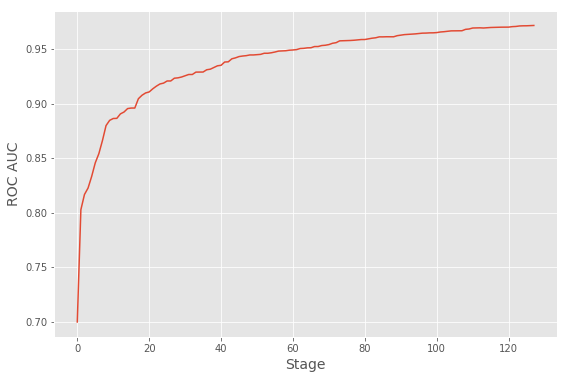

In [27]:
plt.figure(figsize=(9, 6))
plt.plot(np.arange(aucs.shape[0]), aucs)
plt.xlabel('Stage', fontsize=14)
plt.ylabel('ROC AUC',fontsize=14)
plt.show()